<a href="https://colab.research.google.com/github/aplneto/IF1014/blob/main/03-Aprendizagem_por_inst%C3%A2ncias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Antônio Paulino - apln2@cin.ufpe.br
Ailton Rodrigues - ajr@cin.ufpe.br
Douglas Tavares - dtrps@cin.ufpe.br


Realizar as atividades de compreensão do problema, dos dados e a análise
exploratória para o domínio Credit Approval Data Set
(https://archive.ics.uci.edu/ml/datasets/Credit+Approval).
Apresentar relatórios com o itens mencionados e discussões com gráficos da base
de dados.
'''

DATA_FOLDER = (
    'https://archive.ics.uci.edu/ml/machine-learning-databases/'
    'credit-screening/'
)

DATA_DESCRIPTION = DATA_FOLDER + 'crx.names'
DATA_SET = DATA_FOLDER + 'crx.data'

In [ ]:
import pandas
import numpy

aliases = ['A%i' % i for i in range(1, 16)] + ['class']
data = pandas.read_csv(DATA_SET, names=aliases, na_values='?', header=None)
data.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,class
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,+


In [ ]:
# test_data = data.sample(frac=0.2)
# data = pandas.concat([data, test_data]).drop_duplicates(keep=False)

 
**Separa os atributos em categóricos e contínuos**


In [ ]:
continuous = data.describe().columns
categorical = data.drop(list(continuous) + ['class'], axis=1).columns
print(continuous)
print(categorical)

Index(['A2', 'A3', 'A8', 'A11', 'A14', 'A15'], dtype='object')
Index(['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13'], dtype='object')


**Limpeza dos dados**


## Modelo de regressão linear para  completar dados continuos faltantes

Variáveis continuas ausentes serão preenchidas por valores previstos a partir de um modelo de regressão linear construído a partir da coluna com valores ausentes e da coluna com todos os valores mais fortemente correlacionada a ela

In [ ]:
continuous_columns_missing_values = []

for column in continuous:
  if data[column].isnull().sum() > 0:
    continuous_columns_missing_values.append(column)

print(continuous_columns_missing_values)

['A2', 'A14']


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
most_correlated_columns = {}
candidates = [
  x for x in continuous if x not in continuous_columns_missing_values
]
for column in continuous_columns_missing_values:
  most_correlated_columns[column] = max(
      candidates, key=lambda x: abs(data[x].corr(data[column]))
  )

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
prediction_models = {}

for pair in most_correlated_columns.items():
  rows = data[~data[list(pair)].isnull().any(axis=1)][list(pair)]
  y = rows[pair[0]]
  x = rows[pair[1]]
  lr = LinearRegression()
  lr.fit(x.values.reshape(-1, 1), y)
  d = pandas.DataFrame(data= {
      'value' : lr.predict(data[pair[1]].values.reshape(-1, 1))
  })
  data[pair[0]] = numpy.where(data[column].isna(), d['value'], data[column])

data[continuous].isna().sum()

A2     0
A3     0
A8     0
A11    0
A14    0
A15    0
dtype: int64

# Dados categóricos

Algoritmos de machine learning se baseia na construção e no uso de algoritmos que “aprendem” a partir dos dados. Sendo assim,
é preciso converter informações qualitativas em quantitativas para que estas possam ser operadas numericamente. 

Nesta análise, as variáveis categóricas do dataset foram convertidas em números inteiros usando o LabelEncoder da biblioteca sklearn. Os valores ausentes foram completados usando um algoritmo de árvore de decisão.

Atributos categóricos do dataset escolhido pra análise

In [ ]:
categorical_columns_missing_values = [
  p[0] for p in dict(data[categorical].isna().sum() > 0).items() if p[1]
]
complete_data = data.dropna()
print(categorical_columns_missing_values)

['A1', 'A4', 'A5', 'A6', 'A7']


Conversão para números inteiros usando o LabelEncoder da biblioteca Sklearn

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

label_dict = defaultdict(LabelEncoder)
complete_data = complete_data.apply(
    lambda x: label_dict[x.name].fit_transform(x)
    if x.name in list(categorical) + ['class']
    else x
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
trees = {}

X = complete_data.drop(categorical_columns_missing_values, axis=1)

for column in categorical_columns_missing_values:
  Y = complete_data[column]
  tree = DecisionTreeClassifier(
      max_leaf_nodes=Y.nunique(), random_state=2**Y.nunique()
  )

  trees[column] = tree
  tree.fit(X.values, Y.values)

In [ ]:
for column in trees:
  tree = trees[column]
  encoder = label_dict[column]
  d = pandas.DataFrame(data= {
      'value' : encoder.inverse_transform(
          tree.predict(
          data.drop(categorical_columns_missing_values, axis=1).apply(
                  lambda x: label_dict[x.name].fit_transform(x)
                  if x.name in list(categorical) + ['class']
                  else x
          ).values
        )
      )
    }
  )

  data[column] = numpy.where(data[column].isna(), d['value'], data[column])

In [ ]:
labels = data['class']
data.drop('class', axis=1, inplace=True)
X = data.apply(
    lambda x: label_dict[x.name].fit_transform(x)
    if x.name in categorical
    else x
)
print(X)

     A1     A2      A3  A4  A5  A6  A7  ...  A9  A10  A11  A12  A13    A14  A15
0     1  202.0   0.000   1   0  12   7  ...   1    1    1    0    0  202.0    0
1     0   43.0   4.460   1   0  10   3  ...   1    1    6    0    0   43.0  560
2     0  280.0   0.500   1   0  10   3  ...   1    0    0    0    0  280.0  824
3     1  100.0   1.540   1   0  12   7  ...   1    1    5    1    0  100.0    3
4     1  120.0   5.625   1   0  12   7  ...   1    0    0    0    2  120.0    0
..   ..    ...     ...  ..  ..  ..  ..  ...  ..  ...  ...  ...  ...    ...  ...
685   1  260.0  10.085   2   2   4   3  ...   0    0    0    0    0  260.0    0
686   0  200.0   0.750   1   0   1   7  ...   0    1    2    1    0  200.0  394
687   0  200.0  13.500   2   2   5   2  ...   0    1    1    1    0  200.0    1
688   1  280.0   0.205   1   0   0   7  ...   0    0    0    0    0  280.0  750
689   1    0.0   3.375   1   0   1   3  ...   0    0    0    1    0    0.0    0

[690 rows x 15 columns]


# Codificação dos rótulos 

In [ ]:
Y = label_dict['class'].fit_transform(labels)

# Y = pandas.get_dummies(labels, prefix='', prefix_sep='')
# print(Y)

# Transformação dos Dados

In [ ]:
X[continuous].describe()

,A2,A3,A8,A11,A14,A15
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,181.120217,4.758725,2.223406,2.40000,184.094523,1017.385507
std,173.424884,4.978163,3.346513,4.86294,172.233363,5210.102598
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,60.000000,1.000000,0.165000,0.00000,80.000000,0.000000
50%,160.000000,2.750000,1.000000,0.00000,160.000000,5.000000
75%,272.000000,7.207500,2.625000,3.00000,272.000000,395.500000
max,2000.000000,28.000000,28.500000,67.00000,2000.000000,100000.000000


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scalers = defaultdict(StandardScaler)

for column in continuous:
  scaler = scalers[column]
  X[column] = scaler.fit_transform(X[column].values.reshape(-1, 1))

X[continuous].describe()

,A2,A3,A8,A11,A14,A15
count,6.900000e+02,6.900000e+02,6.900000e+02,6.900000e+02,6.900000e+02,6.900000e+02
mean,1.834282e-17,1.605801e-16,1.673380e-16,1.153667e-15,-5.631566e-17,-2.916347e-17
std,1.000725e+00,1.000725e+00,1.000725e+00,1.000725e+00,1.000725e+00,1.000725e+00
min,-1.045130e+00,-9.566132e-01,-6.648767e-01,-4.938866e-01,-1.069642e+00,-1.954133e-01
25%,-6.989082e-01,-7.555902e-01,-6.155359e-01,-4.938866e-01,-6.048191e-01,-1.954133e-01
50%,-1.218714e-01,-4.037999e-01,-3.658414e-01,-4.938866e-01,-1.399961e-01,-1.944530e-01
75%,5.244098e-01,4.922602e-01,1.200908e-01,1.234717e-01,5.107561e-01,-1.194481e-01
max,1.049561e+01,4.672031e+00,7.857628e+00,1.329378e+01,1.055093e+01,1.901199e+01


# Redução de dimensionalidade

<!--

* https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

 -->

## Principal component analysis

<!--

* https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis
* https://www.youtube.com/watch?v=FgakZw6K1QQ
* https://jmausolf.github.io/code/pca_in_python/

-->

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
pca.fit(X[continuous])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(numpy.cumsum(pca.explained_variance_ratio_))

[0.36587965 0.61023383 0.77150117 0.88939291 0.99865368 1.        ]


A partir da análise PCA é possível concluir que uma representação com os componentes principais PC1, PC2, PC3 e PC4 são responsáveis por 96% da variabilidade do dataset e podem ser usados para representar os dados com um elevado nível de fidelidade.

In [ ]:
loadings = pandas.DataFrame(
    pca.components_.T,
    columns = ['PC%d' % (i) for i in numpy.arange(pca.n_components_)+1], index=X[continuous].columns
)

In [ ]:
pca_X = pandas.DataFrame(
    data = pca.fit_transform(X[continuous]),
    columns = ['PC%d' % (i) for i in numpy.arange(pca.n_components_)+1]
)

max_column = numpy.argmax(numpy.cumsum(pca.explained_variance_ratio_) > 0.9) + 1
principal_components = pca_X.columns[:max_column:]

pca_X = pandas.concat(
    [pca_X[principal_components], X[categorical]],
    axis = 1
)

# Modelos de aprendizagem por intâncias

## Funções auxiliares

In [ ]:
from sklearn.datasets import make_blobs

def visualize_2d_graph(model, n_samples=100, test_n=10, is_lvq=True):

  x, y = make_blobs(n_samples=n_samples, centers=2, n_features=2)
  model.fit(x, y)

  class_0 = x[y < 1]
  class_1 = x[y > 0]

  fig, ax = plt.subplots()
  ax.scatter(*zip(*class_0), color='red', label='class 0')
  ax.scatter(*zip(*class_1), color='blue', label='class 1')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.yaxis.tick_left()
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')
  ax.xaxis.tick_bottom()

  if is_lvq:
    ax.scatter(*model.prototypes[0], s=[100], color='black', label='proto 0')
    ax.scatter(*model.prototypes[1], s=[100], color='grey', label='proto 1')

  test_p = numpy.random.randint(-10, 10, size=(10, 2))
  y_pred = model.predict(test_p)
  y_0 = test_p[y_pred < 1]
  y_1 = test_p[y_pred > 0]
  ax.scatter(*zip(*y_0), color='orange', marker='*', label='pred 0')
  ax.scatter(*zip(*y_1), color='green', marker='*', label='pred 1')
  ax.legend()

  plt.show()

## [Learning Vector Quantization Classifier](https://outline.com/dJvFUv)

LVQ é o chamado método de aprendizagem baseado em protótipo. Um ou mais protótipos são usados ​​para representar cada classe no conjunto de dados, cada protótipo é descrito como um ponto no espaço de características. Novos pontos de dados (desconhecidos) são então atribuídos à classe do protótipo que está mais próxima deles. Para que “mais próximo” faça sentido, a medida de distância euclidiana foi definida pra esta análise.

O LVQ pode ser entendido como um caso especial de rede neural artificial, mais precisamente, ele aplica uma abordagem baseada na  Hebbian learning do vencedor leva tudo. É um precursor de Self-Organizing Map (SOM) e relacionado ao algoritmo k-vizinho mais próximo (k-NN). LVQ foi inventado por Teuvo Kohonen.

In [ ]:
class LVQClassifier():
  def __init__(
      self, distance_metrics='euclidian', learning_rate=0.01, max_iter=200
):
    self.__distance_functions = {
        'euclidian': lambda v: numpy.linalg.norm(v)
    }
    assert distance_metrics in self.__distance_functions
    self.__learning_rate = learning_rate
    self.__choosen_distance_function = distance_metrics
    self.__prototypes = None
    self.__max_iter=200
  
  @property
  def prototypes(self):
    return self.__prototypes
  
  @property
  def params(self):
    return {
        'distance': self.__choosen_distance_function,
        'learning_rate': self.__learning_rate,
        'max_iter': self.__max_iter
    }

  def partial_fit(self, X: numpy.ndarray, Y: numpy.ndarray):
    fn = self.__distance_functions[self.__choosen_distance_function]
    assert len(X) == len(Y)
    assert len(X.shape) == 2
    unique = numpy.unique(Y)
    proto_n = unique.shape[0]
    if self.__prototypes is None:
      self.__prototypes = numpy.zeros((proto_n, X.shape[1]))
    for class_ in unique:
      examples = X[Y == class_]
      self.__prototypes[class_] = numpy.average(examples, axis=0)
    diff = numpy.zeros(self.__prototypes.shape)
    distances = numpy.zeros((len(self.__prototypes), ))
    for i, x in enumerate(X):
      y = Y[i]
      for class_, proto in enumerate(self.__prototypes):
        diff[class_] = x - proto
        distances[class_] = fn(diff[class_])
      closest = numpy.argmin(distances)
      minor_d = numpy.argmin(diff[closest])
      lr = self.__learning_rate if class_ == y else -1 * self.__learning_rate
      self.__prototypes[closest][minor_d] += (
          lr if self.__prototypes[closest][minor_d] < x[minor_d] else -1 * lr
      )
    
  def fit(self, X: numpy.ndarray, Y: numpy.ndarray):
    i = 0
    while i < self.__max_iter:
      self.partial_fit(X, Y)
      i += 1
    
  def predict(self, X: numpy.ndarray):
    fn = self.__distance_functions[self.__choosen_distance_function]
    if (self.__prototypes is None):
      raise ValueError("Classifier not yet initialized")
    if (self.__prototypes.shape[1] != len(X[0])):
      raise ValueError(
          "Expected array with {0} dimensions. Got {1} instead".format(
              self.__prototypes.shape[1], len(X[0])
          )
      )
    distances = numpy.zeros((len(self.__prototypes), ))
    Y = numpy.zeros((len(X), ))
    for i, x in enumerate(X):
      for class_, proto in enumerate(self.__prototypes):
        distances[class_] = fn(x - proto)
      Y[i] = numpy.argmin(distances)
    return Y


### 2D Visualization

Analisando o gráfico abaixo, observa-se que cada classe (vermelho e azul) é representada por um protótipo (os pontos maiores) ou seja proto O para classe azul e proto 1 para a classe vermelha

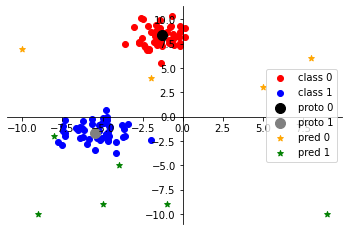

In [ ]:
lvq = LVQClassifier()
visualize_2d_graph(lvq)

## [k-Nearest Neighbours Classifier]()

O algoritmo k-vizinhos mais próximos (do inglês, *k-Nearest Neighbors – kNN*) funciona da seguinte forma: dada uma instância de teste xq, o algoritmo encontra os k vizinhos mais próximos de xq no conjunto de treinamento. 

Em seguida, a classe de xq é dada pela classe que ocorrer com maior frequência entre os k vizinhos. 

Esse algoritmo possui dois parâmetros: o número de vizinhos (k) e a medida de dissimilaridade (ou de similaridade) usada para encontrar os vizinhos mais próximos. A distância Euclidiana é a medida mais amplamente usada para determinar os vizinhos, embora existam diversas opções. 

O KNN é um algoritmo de aprendizagem preguiçosa, que a função alvo é aproximada localmente, ou seja, o algoritmo k-NN sabe resolver com sucesso com mudanças no domínio do problema, cada novo elemento que é adicionando no dataset é calculado, essa seria uma desvantagem da aprendizagem preguiçosa, pois precisa armazenar o dataset inteiro. 
O k-NN é um dos algoritmos mais simples de ser implementado de aprendizagem de máquina, de fácil compreensão dos resultados e algumas aplicações atualmente podem ter bons resultados com o algoritmo do k-NN. O k-NN é utilizado para os problemas de classificação e de regressão. Porém é mais utilizado em problemas de classificação na indústria.

Precisamos entender como o valor de “K” afetar o algoritmo k-NN e como o dataset é classificado, se os resultados melhoram ou pioram.


In [ ]:
class KNNClassifier():
  def __init__(self, k = 5):
    self.__k = k
    self.__X = None
    self.__Y = None
  
  @property
  def params(self):
    return {'k': self.__k}
  
  def fit(self, X: numpy.ndarray, Y: numpy.ndarray):
    assert len(X) == len(Y)
    assert len(X.shape) == 2
    self.__X = X if self.__X is None else numpy.concatenate((self.__X, X))
    self.__Y = Y if self.__Y is None else numpy.concatenate((self.__Y, Y))
  
  def predict(self, X: numpy.ndarray):
    predictions = numpy.zeros((len(X), ))
    dist = numpy.zeros((len(self.__X, )))
    for i, x in enumerate(X):
      for j, v in enumerate(self.__X):
        dist[j] = numpy.linalg.norm(x - v)
      k_nearest = dist.argsort()[:self.__k]
      values, counts = numpy.unique(self.__Y[k_nearest], return_counts=True)
      predictions[i] = values[numpy.argmax(counts)]
    return predictions

### 2D Visualization

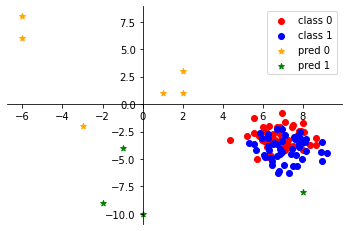

In [ ]:
knn = KNNClassifier()
visualize_2d_graph(knn, is_lvq=False)

# Testes

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    pca_X, Y, test_size = 0.2, random_state = 4
)

## KNN

In [ ]:
!pip3 install memory_profiler
import time
from memory_profiler import memory_usage

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-py3-none-any.whl size=30190 sha256=f0f68be1127489e1da2eadd44d516b82b52e60a038fe863a85ac0442437459ac
  Stored in directory: /root/.cache/pip/wheels/56/19/d5/8cad06661aec65a04a0d6785b1a5ad035cb645b1772a4a0882
Successfully built memory-profiler


In [ ]:
predictions = []
time_list = []
mem_list = []

for k in range(1, 10, 2):
  knn = KNNClassifier(k=k)
  knn.fit(X_train.values, Y_train)
  T_InitKnn = time.process_time() 
  y_pred = knn.predict(X_test.values)
  T_FinishKnn = time.process_time()
  T_PredictKnn = T_FinishKnn - T_InitKnn

  predictions.append(y_pred)
  time_list.append(T_PredictKnn)
  mem = memory_usage()
  print(mem)

[204.38671875]
[204.38671875]
[204.38671875]
[204.38671875]
[204.38671875]


Big O do KNN é O(n*m), onde n é número de exemplos de instâncias do dataset e o m é o número de predições.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
names = label_dict['class'].inverse_transform([0, 1])
for idx, y_pred in enumerate(predictions):
  print("K = %i" % (2*idx+1))
  print(classification_report(Y_test, y_pred, target_names=names))
  print("Tempo decorrido:", time_list[idx])

K = 1
              precision    recall  f1-score   support

           +       0.67      0.67      0.67        58
           -       0.76      0.76      0.76        80

    accuracy                           0.72       138
   macro avg       0.72      0.72      0.72       138
weighted avg       0.72      0.72      0.72       138

Tempo decorrido: 0.6227671600000022
K = 3
              precision    recall  f1-score   support

           +       0.71      0.62      0.66        58
           -       0.75      0.81      0.78        80

    accuracy                           0.73       138
   macro avg       0.73      0.72      0.72       138
weighted avg       0.73      0.73      0.73       138

Tempo decorrido: 0.6174500739999971
K = 5
              precision    recall  f1-score   support

           +       0.79      0.64      0.70        58
           -       0.77      0.88      0.82        80

    accuracy                           0.78       138
   macro avg       0.78      0.76     

## LVQ

In [ ]:
!pip3 install optuna
import optuna
from sklearn.metrics import accuracy_score

     |████████████████████████████████| 308 kB 9.2 MB/s 
     |████████████████████████████████| 209 kB 56.7 MB/s 
     |████████████████████████████████| 80 kB 9.6 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 144 kB 76.9 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 111 kB 46.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=a92cae718d78373bd0b7cbf9f083345259d81287a29357d094c10e0b70cf9340
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def lvq_model_factory(learning_rate: float, max_iter: int):
  return LVQClassifier('euclidian', learning_rate, max_iter)

def lvq_optimizer(trial: optuna.trial._frozen.FrozenTrial):
  learning_rate = trial.suggest_categorical('learning_rate', [0.1, 0.01, 0.001])
  max_iter = trial.suggest_int('max_iter', 200, 1000, 200)
  classifier = lvq_model_factory(learning_rate, max_iter)
  classifier.fit(X_train.values, Y_train)

  T_InitLvq = time.process_time() 

  y_pred = classifier.predict(X_test.values)

  T_FinishLvq = time.process_time()
  T_PredictLvQ = T_FinishLvq - T_InitLvq

  print(classification_report(Y_test, y_pred, target_names=names))
  print("Time:", T_PredictLvQ)
  
  return accuracy_score(Y_test, y_pred)

Big O do LVQ é O(m), onde m é o número de predições.

In [ ]:
study = optuna.study.create_study(direction='maximize')
study.optimize(lvq_optimizer, n_trials = 20)

[I 2021-10-19 23:41:18,059] A new study created in memory with name: no-name-e1d299a2-2096-4d6a-bbbc-9256ef093b0a
[I 2021-10-19 23:41:21,121] Trial 0 finished with value: 0.5579710144927537 and parameters: {'learning_rate': 0.1, 'max_iter': 600}. Best is trial 0 with value: 0.5579710144927537.


              precision    recall  f1-score   support

           +       0.48      0.67      0.56        58
           -       0.67      0.47      0.55        80

    accuracy                           0.56       138
   macro avg       0.57      0.57      0.56       138
weighted avg       0.59      0.56      0.56       138

Time: 0.0030121669999800815


[I 2021-10-19 23:41:24,122] Trial 1 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.002767141999981959


[I 2021-10-19 23:41:27,141] Trial 2 finished with value: 0.5942028985507246 and parameters: {'learning_rate': 0.01, 'max_iter': 200}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.52      0.53      0.53        58
           -       0.65      0.64      0.65        80

    accuracy                           0.59       138
   macro avg       0.59      0.59      0.59       138
weighted avg       0.60      0.59      0.60       138

Time: 0.002778458999983968


[I 2021-10-19 23:41:30,169] Trial 3 finished with value: 0.5942028985507246 and parameters: {'learning_rate': 0.01, 'max_iter': 1000}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.52      0.53      0.53        58
           -       0.65      0.64      0.65        80

    accuracy                           0.59       138
   macro avg       0.59      0.59      0.59       138
weighted avg       0.60      0.59      0.60       138

Time: 0.0027588780000087354


[I 2021-10-19 23:41:33,195] Trial 4 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027903040000012425


[I 2021-10-19 23:41:36,248] Trial 5 finished with value: 0.5579710144927537 and parameters: {'learning_rate': 0.1, 'max_iter': 400}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.48      0.67      0.56        58
           -       0.67      0.47      0.55        80

    accuracy                           0.56       138
   macro avg       0.57      0.57      0.56       138
weighted avg       0.59      0.56      0.56       138

Time: 0.002795531000003848


[I 2021-10-19 23:41:39,281] Trial 6 finished with value: 0.5579710144927537 and parameters: {'learning_rate': 0.1, 'max_iter': 600}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.48      0.67      0.56        58
           -       0.67      0.47      0.55        80

    accuracy                           0.56       138
   macro avg       0.57      0.57      0.56       138
weighted avg       0.59      0.56      0.56       138

Time: 0.0028808550000007926


[I 2021-10-19 23:41:42,333] Trial 7 finished with value: 0.5579710144927537 and parameters: {'learning_rate': 0.1, 'max_iter': 1000}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.48      0.67      0.56        58
           -       0.67      0.47      0.55        80

    accuracy                           0.56       138
   macro avg       0.57      0.57      0.56       138
weighted avg       0.59      0.56      0.56       138

Time: 0.002736405999996805


[I 2021-10-19 23:41:45,359] Trial 8 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 600}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.002787578999999596


[I 2021-10-19 23:41:48,389] Trial 9 finished with value: 0.5579710144927537 and parameters: {'learning_rate': 0.1, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.48      0.67      0.56        58
           -       0.67      0.47      0.55        80

    accuracy                           0.56       138
   macro avg       0.57      0.57      0.56       138
weighted avg       0.59      0.56      0.56       138

Time: 0.0028315869999744336


[I 2021-10-19 23:41:51,448] Trial 10 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0028076769999927365


[I 2021-10-19 23:41:54,462] Trial 11 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.002755309999997735


[I 2021-10-19 23:41:57,501] Trial 12 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027122170000097867


[I 2021-10-19 23:42:00,540] Trial 13 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 1000}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027227230000050895


[I 2021-10-19 23:42:03,567] Trial 14 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 400}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027336219999938294


[I 2021-10-19 23:42:06,601] Trial 15 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 800}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027150850000055016


[I 2021-10-19 23:42:09,609] Trial 16 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 400}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027151620000154253


[I 2021-10-19 23:42:12,632] Trial 17 finished with value: 0.5942028985507246 and parameters: {'learning_rate': 0.01, 'max_iter': 400}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.52      0.53      0.53        58
           -       0.65      0.64      0.65        80

    accuracy                           0.59       138
   macro avg       0.59      0.59      0.59       138
weighted avg       0.60      0.59      0.60       138

Time: 0.002785066999990704


[I 2021-10-19 23:42:15,652] Trial 18 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 600}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.002767258000005768


[I 2021-10-19 23:42:18,658] Trial 19 finished with value: 0.6231884057971014 and parameters: {'learning_rate': 0.001, 'max_iter': 600}. Best is trial 1 with value: 0.6231884057971014.


              precision    recall  f1-score   support

           +       0.55      0.57      0.56        58
           -       0.68      0.66      0.67        80

    accuracy                           0.62       138
   macro avg       0.61      0.62      0.62       138
weighted avg       0.63      0.62      0.62       138

Time: 0.0027527420000126313


#Considerações Finais

Para o algoritmo Knn foram testados os valores de K =1,3,5,7 e 9. 
Com k =5, o Knn obteve uma acurácia de 0.78 com um tempo de predição de 0.590 ms, sendo estes os valores ótimos para o conjunto de teste.

Para o algoritmo LVQ foram testados os valores de learning_rate = 0.1, 0.01, 0.001 e max_iter = 200, 400, 600, 800 e 1000.
Com learning_rate = 0.001 e max_iter = 200, obteve uma acurácia de 0.62 com tempo de predição de 0.0028 ms, sendo estes os valores ótimos para o conjunto de teste.

O Algoritmo K-NN apresentou uma melhor acurácia em relação ao LVQ. Com o treinamento do LVQ foi observado que o tempo de predição do LVQ foi 210 vezes mais veloz do que o K-NN, dimunindo assim o custo computacional. O LVQ armazena apenas os protótipos, enquanto o K-NN armazena todo o conjunto de dados, neste caso o LVQ tem uma redução de memória em relação ao K-NN.

#Referências



https://towardsdatascience.com/ml-algorithms-one-sd-σ-instance-based-algorithms-4349224ed4f3

https://towardsdatascience.com/learning-vector-quantization-ed825f8c807d


https://en.wikipedia.org/wiki/Learning_vector_quantization